## Visualize some voxelized training data

In [3]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import os

In [20]:
# Function inspired from: https://github.com/AutoDeep/VoxNet/blob/master/src/utils/visualization.py

def plot3DVoxel(voxels, title, res):
    fig = plt.figure('3D Voxel',figsize=(6, 6))
    plt3d = fig.add_subplot(111, projection='3d')

    #print(voxels.shape)
    occupied = (voxels == 1)
    free = (voxels == 0)

    colors = np.zeros(voxels.shape + (4,)) # (4,) indicates RGBA, 4 values accosiated with each voxel
    colors[free] = [0.1, 0.1, 0.1, 0.1]
    colors[occupied] = [0.8, 0.8, 0.8, 1.0]

    plt3d.set_xlabel('X', fontsize=9)
    plt3d.set_ylabel('Y', fontsize=9)
    plt3d.set_zlabel('Z', fontsize=9)
    plt3d.set_xlim(0,res)
    plt3d.set_ylim(0,res)
    plt3d.set_zlim(0,res)

    plt3d.voxels(voxels, facecolors=colors, edgecolor='k', linewidth=0.8)
    plt.title(title)
    plt.show()

In [23]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def plotCad(cad_mesh):
    # Extract vertices and faces from the mesh
    vertices = cad_mesh.vertices
    faces = cad_mesh.faces

    # Create a plot
    fig = plt.figure('Mesh plot', figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Create a Poly3DCollection from the faces
    mesh_collection = Poly3DCollection(vertices[faces], facecolors='grey', linewidths=0.5, edgecolors='k', alpha=0.5)

    # Add the collection to the axes
    ax.add_collection3d(mesh_collection)

    # Set plot labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    x_range = [vertices[:, 0].min(), vertices[:, 0].max()]
    y_range = [vertices[:, 1].min(), vertices[:, 1].max()]
    z_range = [vertices[:, 2].min(), vertices[:, 2].max()]

    # Calculate the max range for all axes to make them equal
    max_range = max(np.ptp(x_range), np.ptp(y_range), np.ptp(z_range))

    # Set all axis limits to have the same scale based on max_range
    ax.set_xlim([x_range[0], x_range[0] + max_range])
    ax.set_ylim([y_range[0], y_range[0] + max_range])
    ax.set_zlim([z_range[0], z_range[0] + max_range])

    # Show the plot
    plt.show()

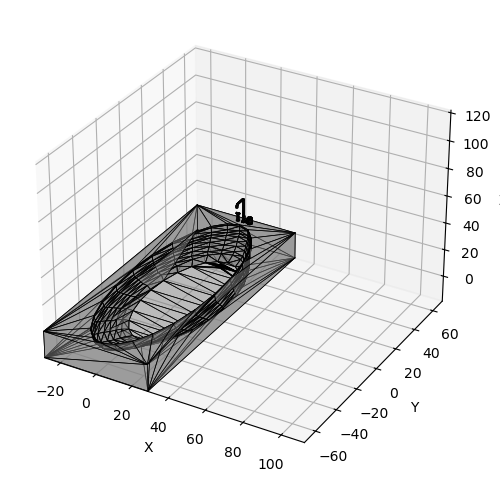

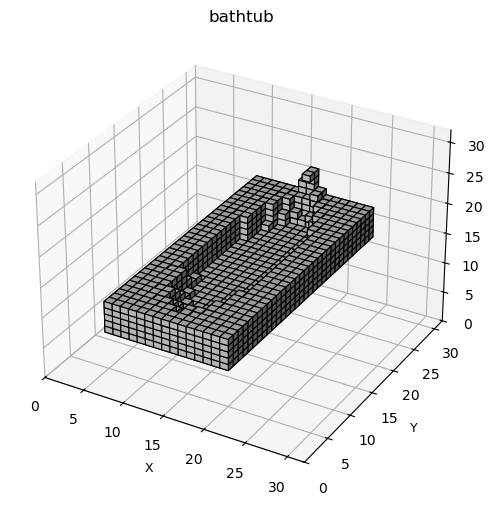

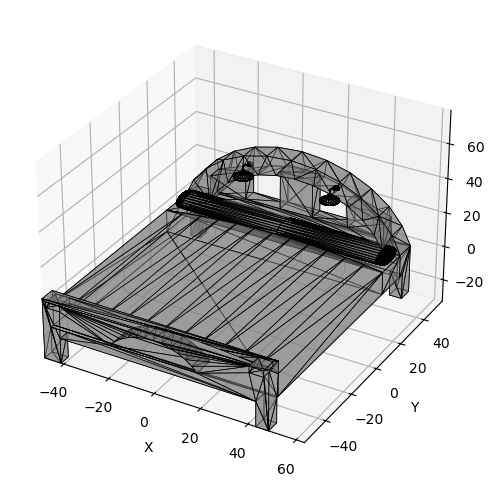

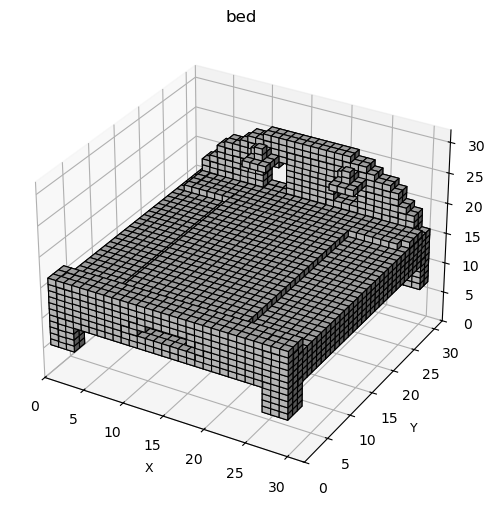

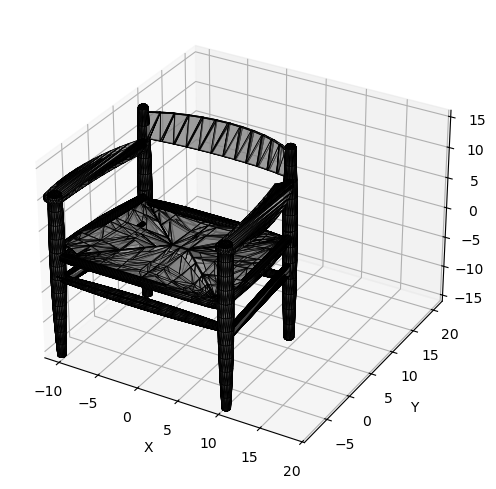

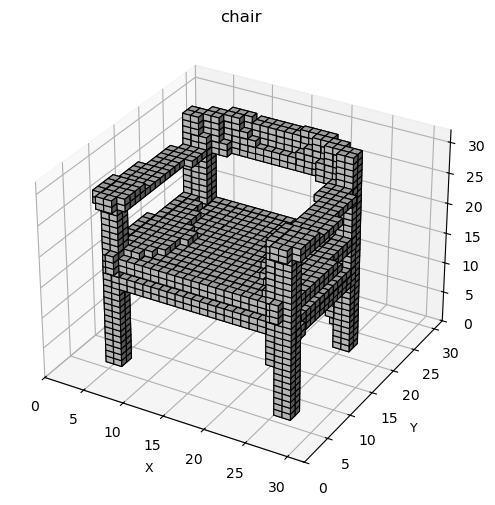

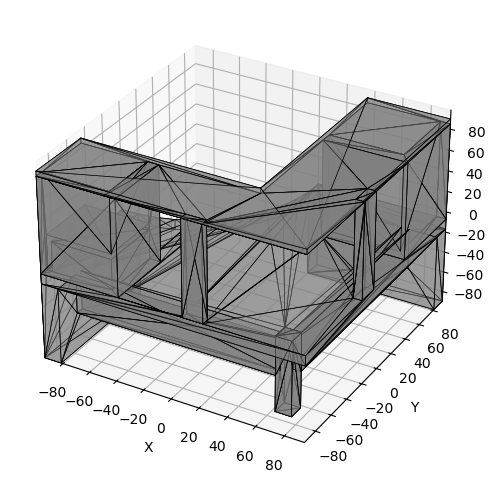

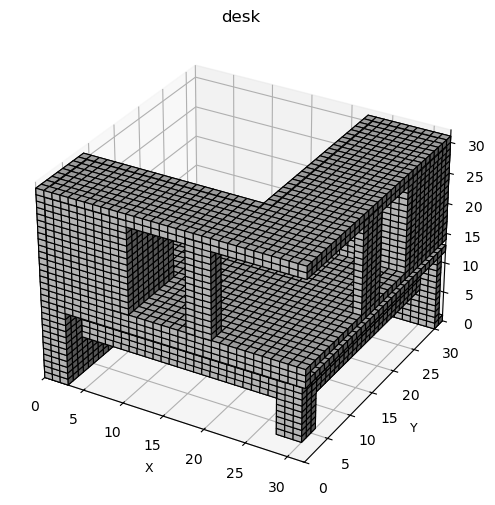

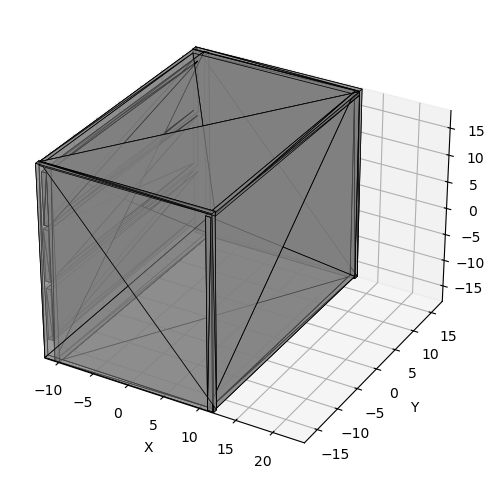

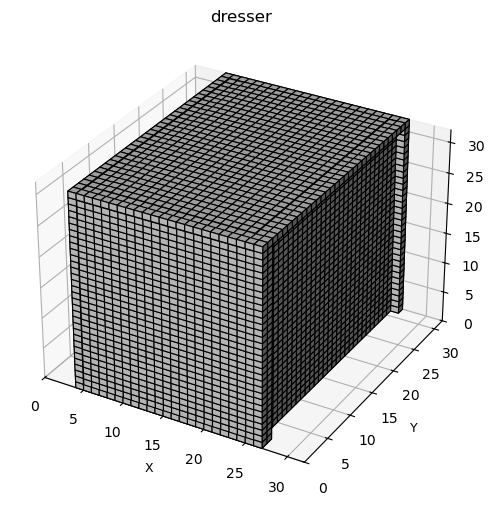

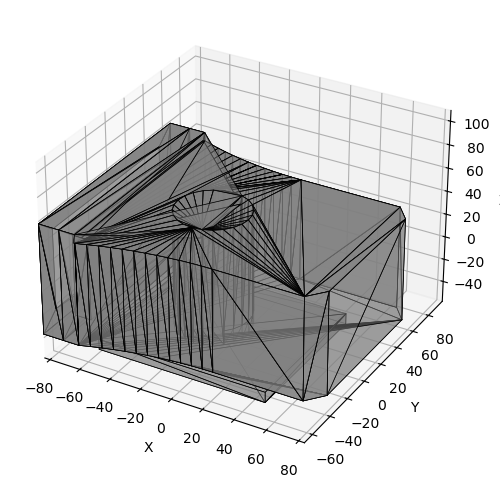

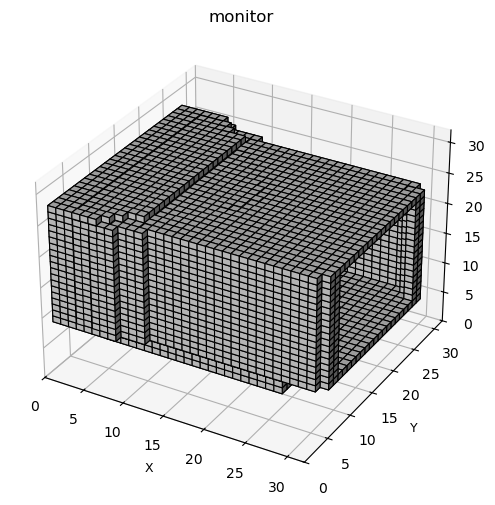

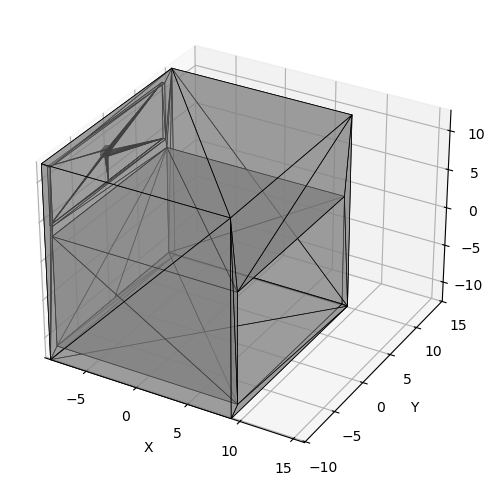

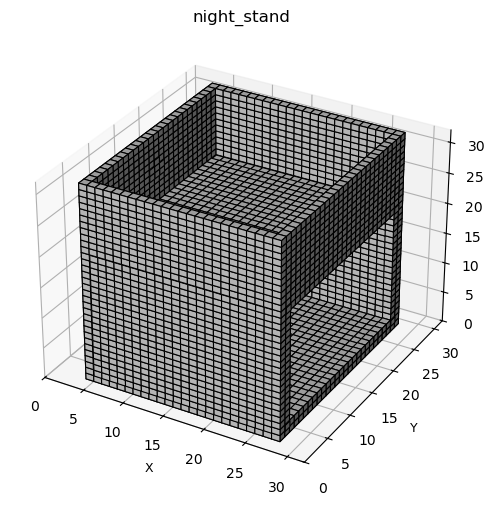

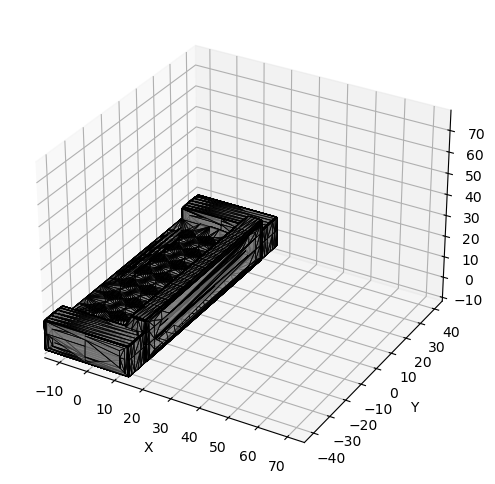

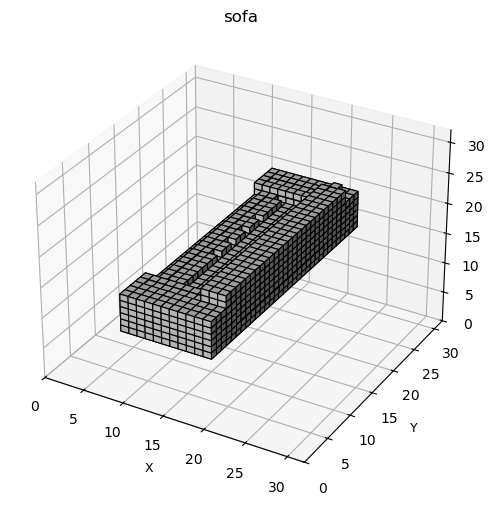

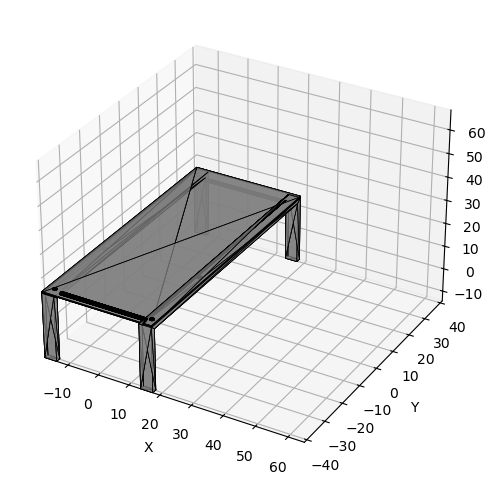

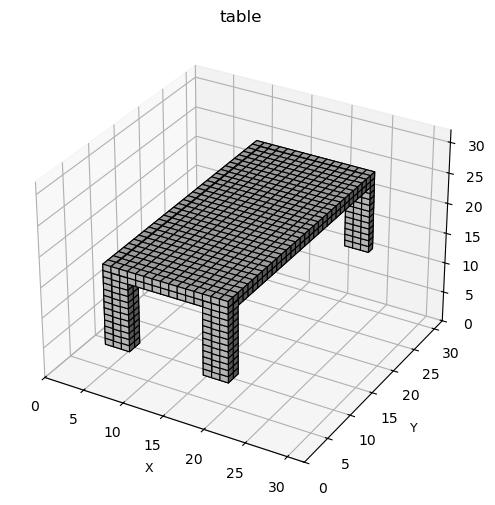

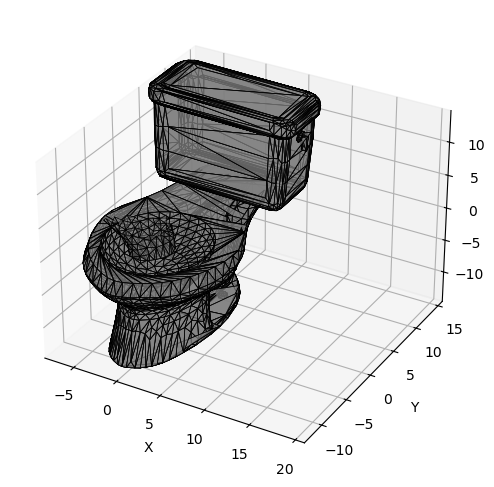

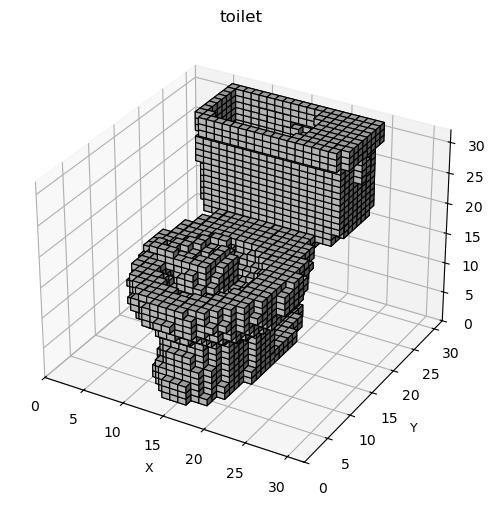

In [24]:
from mpl_toolkits.mplot3d import Axes3D

dataset_directory = "./ModelNet10_voxelized"

for object_folder in os.listdir(dataset_directory):
    if object_folder == "README.txt":
        continue
    object_folder_path = os.path.join(dataset_directory, object_folder)
    train_folder_path = os.path.join(object_folder_path, "train")

    train_vizualize = os.listdir(train_folder_path)
    rand_int = np.random.randint(0, len(train_vizualize))
    obj_vizualise = train_vizualize[rand_int]

    path_obj_vizualise = os.path.join(train_folder_path, obj_vizualise)
    res = 32 
    voxel_grid = np.load(path_obj_vizualise)

    cad_obj_path = path_obj_vizualise.replace("./ModelNet10_voxelized", "../ModelNet10")
    cad_obj_path = cad_obj_path.replace(".npy",".off")
    cad_mesh = trimesh.load(cad_obj_path)

    plotCad(cad_mesh)
    plot3DVoxel(voxel_grid, object_folder, res)  


## Load datasets

In [1]:
from ModelNet10VoxelDataset import ModelNet10VoxelDataset
import torch
import numpy as np
train_data = ModelNet10VoxelDataset("./ModelNet10_voxelized","train",32)

train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=20, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

test_data = ModelNet10VoxelDataset("./ModelNet10_voxelized","test",32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

print(f'Number of training samples: {len(train_data)}.\nNumber of validation samples: {len(val_data)} \nNumber of test samples: {len(test_data)}.')

Number of training samples: 3591.
Number of validation samples: 400 
Number of test samples: 908.


## Define model and setup for training

In [2]:
from VoxNet import VoxNet
import torch

voxnet = VoxNet(10)
print(voxnet)

VoxNet(
  (conv): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
  )
  (classification): Sequential(
    (0): Linear(in_features=6912, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [3]:
from torch.optim.lr_scheduler import LambdaLR
from torch import nn

optimizer = torch.optim.SGD(voxnet.parameters(), lr=0.001,momentum=0.9 ,weight_decay=0.001) # parameters from the paper
scheduler = LambdaLR(optimizer, lr_lambda=lambda batch_idx: 0.1 ** (batch_idx // 40000)) ## each 40000 decrease the lr by a factor of 10

loss_fn = nn.CrossEntropyLoss()


## Train the model

In [4]:
def train_one_epoch(epoch_index):
    total_loss = 0.0

    for batch_idx, (voxels, labels) in enumerate(train_loader):
        logits = voxnet(voxels)

        optimizer.zero_grad()
        loss_cls = loss_fn(logits, labels)
        loss_cls.backward()
        optimizer.step()
        scheduler.step()

        loss_value = loss_cls.item()
        total_loss += loss_value

    return total_loss / len(train_loader)


In [5]:
def validation_one_epoch(epoch_index):
    with torch.no_grad():
        total_loss = 0.0

        for batch_idx, (voxels, labels) in enumerate(val_loader):
            logits = voxnet(voxels)
            loss_cls = loss_fn(logits, labels)

            loss_value = loss_cls.item()
            total_loss += loss_value

        return total_loss / len(val_loader)

In [6]:
def plot_training_validation_loss(train_loss,val_loss):
    plt.plot(np.arange(0,len(train_loss)), train_loss, label='Training loss per batch' )
    plt.plot(np.arange(0,len(val_loss)), val_loss, label='Validation loss per batch')

    plt.vlines(np.argmin(val_loss),ymin=0, ymax=max(max(train_loss),max(val_loss)), linestyle=':',colors='k', label='Minimum validation loss') 

    plt.xlabel('Epochs')
    plt.ylabel('Loss per batch')
    plt.title('Training vs validation loss')
    plt.grid()
    plt.legend()
    plt.show()


In [7]:
epochs = 15
val_loss_data = np.zeros(epochs)
train_loss_data = np.zeros(epochs)

best_val_loss = float('inf')
best_model = None

for epoch in range(0,epochs):
    avg_loss_train = train_one_epoch(epoch)
    avg_loss_val = validation_one_epoch(epoch)

    train_loss_data[epoch] = avg_loss_train
    val_loss_data[epoch] = avg_loss_val

    print(f'>> Epoch {epoch+1} complete. Training loss per epoch: {avg_loss_train:.4f}. Validation loss per epoch: {avg_loss_val:.4f}')

    # Save best model. 
    if (avg_loss_val < best_val_loss):
        best_val_loss = avg_loss_val
        best_model = voxnet.state_dict()



>> Epoch 1 complete. Training loss per epoch: 1.8501. Validation loss per epoch: 1.0335
>> Epoch 2 complete. Training loss per epoch: 0.7361. Validation loss per epoch: 0.6282
>> Epoch 3 complete. Training loss per epoch: 0.5493. Validation loss per epoch: 0.4788
>> Epoch 4 complete. Training loss per epoch: 0.4720. Validation loss per epoch: 0.4671
>> Epoch 5 complete. Training loss per epoch: 0.4029. Validation loss per epoch: 0.4471
>> Epoch 6 complete. Training loss per epoch: 0.3808. Validation loss per epoch: 0.4432
>> Epoch 7 complete. Training loss per epoch: 0.3509. Validation loss per epoch: 0.3946
>> Epoch 8 complete. Training loss per epoch: 0.3433. Validation loss per epoch: 0.3945
>> Epoch 9 complete. Training loss per epoch: 0.3261. Validation loss per epoch: 0.3360
>> Epoch 10 complete. Training loss per epoch: 0.3224. Validation loss per epoch: 0.3531
>> Epoch 11 complete. Training loss per epoch: 0.3005. Validation loss per epoch: 0.3060
>> Epoch 12 complete. Training

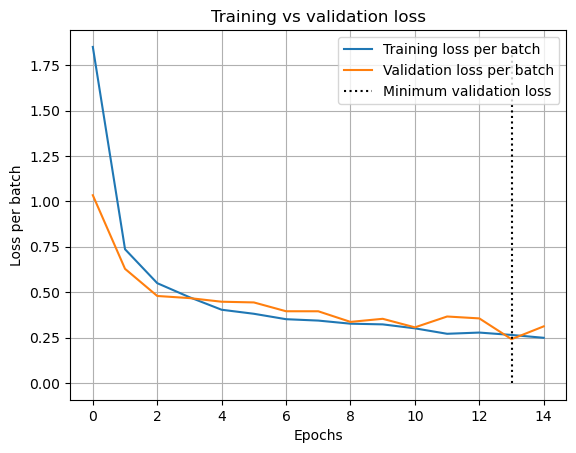

In [8]:
import matplotlib.pyplot as plt
plot_training_validation_loss(train_loss_data, val_loss_data)

In [9]:
torch.save(best_model, 'voxnet.pth')

## Test model

In [10]:
from VoxNet import VoxNet
import torch
voxnet = VoxNet(10)
voxnet.load_state_dict(torch.load('voxnet.pth'))

C:\Users\eric_\AppData\Local\Temp\ipykernel_9936\2563123834.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  voxnet.load_state_dict(torch.load('voxnet.pth'))


<All keys matched successfully>

In [11]:
voxnet.eval()
correct_predictions = 0.0  
running_cls_loss = 0.0
total_samples = 0


with torch.no_grad():
    for batch_idx, (voxels, labels) in enumerate(test_loader):

        logits = voxnet(voxels)

        loss_cls = loss_fn(logits, labels)

        running_cls_loss += loss_cls.item()

        total_samples += voxels.size(0)

        predicted = torch.argmax(logits, dim=1) 

        correct_predictions += (predicted == labels).sum().item()

    avg_loss_cls = running_cls_loss / len(test_loader)
    accuracy = 100 * correct_predictions / total_samples
    print(f'Classification Loss: {avg_loss_cls:.4f}, Classification Accuracy: {accuracy:.2f}%')

Classification Loss: 0.3693, Classification Accuracy: 86.89%


## Show results using confusion matrix


In [12]:
from seaborn import cubehelix_palette, heatmap
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(classifier, dataloader, dataset):
    """Plot confusion matrix."""
    confusion_matrix = np.zeros((10, 10), dtype=int)
    for voxels,labels in dataloader:
        logits = classifier(voxels)
        predicted = torch.argmax(logits, dim=1) 
        for pred, label in zip(predicted, labels):
            np.add.at(confusion_matrix, (label, pred), 1)

    # Normalize per row (ground truth)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    confusion_matrix_normalized = np.divide(confusion_matrix, row_sums, where=row_sums!=0)

    # Use dataset mapper to convert integer labels to string labels.
    tick_labels = [dataset.idx_to_class[i] for i in range(len(dataset.idx_to_class))]

    plt.figure(figsize=(10, 8))
    ax = heatmap(confusion_matrix_normalized, annot=True, fmt=".2f", square=True,
                cmap=cubehelix_palette(light=0.95, as_cmap=True), vmin=0.0, vmax=1.0)

    # Map idx labels to text labels.
    ax.set_xticklabels(tick_labels, rotation=45)
    ax.set_yticklabels(tick_labels, rotation=0) 

    plt.xlabel("Predicted object", fontsize=15)
    plt.ylabel("Ground truth object", fontsize=15)
    plt.title("VoxNet Confusion Matrix on ModelNet10", fontsize=16)
    plt.show()

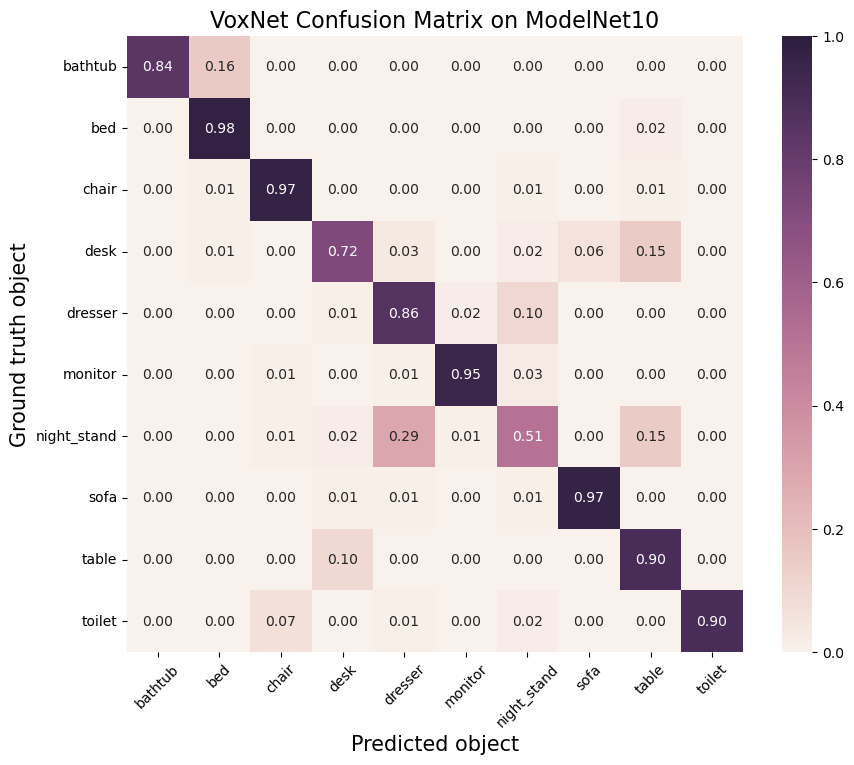

In [13]:
plot_confusion_matrix(voxnet, test_loader, test_data)

In [14]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_trainable_params(voxnet)

print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 917866


## Comments

To increase accuracy further, one approach could be to rotate the objects during training, such that the network hopefully learns to distinguish better between table/night stand/ desk.